- We want to introuce heterogeneity through initialising agents with varying characteristics (etc some agents are more risk averse). This can be done through varying the hyperparameters of the Q-function.  
- To introduce herding, we can

#First Version (Without Herding)

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def el_farol_baseline(
    N=100,        # Number of agents
    C=60,         # Capacity of the bar
    T=200,        # Number of rounds (episodes)
    alpha=0.1,    # Learning rate
    gamma=0.0,    # Discount factor
    epsilon=0.1   # Epsilon for epsilon-greedy
):
    """
    Implements a baseline El Farol Bar scenario using multi-agent Q-learning.
    Returns:
      - attendances_per_round: list of total attendance in each round
      - rewards_per_round: list of total rewards collected by all agents each round
    """

    # Each agent has a Q-table:
    # Q[i, s, a] = Q-value for agent i, given the previous round's attendance 's', taking action 'a'
    # 's' can range from 0 to N, 'a' in {0, 1} = {Stay home, Attend}
    Q = np.zeros((N, N+1, 2))

    # Initialize all Q-values to small random numbers (optional, to break symmetry)
    Q += np.random.uniform(-0.01, 0.01, (N, N+1, 2))

    # We start with an arbitrary 'last attendance' state, e.g. 0
    current_state = 0

    attendances_per_round = []
    rewards_per_round = []

    for t in range(T):

        # --- 1. Each agent chooses an action (attend or not) based on epsilon-greedy from Q-table ---
        actions = []
        for i in range(N):
            # Epsilon-greedy selection
            if random.random() < epsilon:
                # Explore: pick a random action
                action = np.random.choice([0, 1])
            else:
                # Exploit: pick the action with the highest Q-value
                action = np.argmax(Q[i, current_state, :])

            actions.append(action)

        # --- 2. Calculate total attendance this round ---
        total_attendance = sum(actions)

        # --- 3. Compute rewards for each agent and update Q-values ---
        # The new state is defined as the current round's attendance (total_attendance)
        new_state = total_attendance

        # We'll track the sum of rewards this round (for analysis)
        round_reward_sum = 0

        for i in range(N):
            # Reward logic
            if actions[i] == 1 and total_attendance <= C:
                reward = 1.0
            elif actions[i] == 0 and total_attendance >= C:
                reward = 1.0
            else:
                reward = 0.0

            round_reward_sum += reward

            # Q-learning update
            old_value = Q[i, current_state, actions[i]]

            # Future best (since we have 2 actions, we look at Q[i, new_state, 0] and Q[i, new_state, 1])
            best_future = np.max(Q[i, new_state, :])

            # TD update
            new_value = old_value + alpha * (reward + gamma * best_future - old_value)

            Q[i, current_state, actions[i]] = new_value

        # --- 4. Prepare for next round ---
        current_state = new_state

        # Store stats
        attendances_per_round.append(total_attendance)
        rewards_per_round.append(round_reward_sum)

    return attendances_per_round, rewards_per_round


# ---- MAIN SCRIPT / DEMO ----
if __name__ == "__main__":
    # Hyperparameters
    N = 100
    C = 60
    T = 200
    alpha = 0.1
    gamma = 0.0
    epsilon = 0.1

    # Run simulation
    attendances, rewards = el_farol_baseline(N, C, T, alpha, gamma, epsilon)

#Second Version

In [ ]:
def el_farol_herding(
    N=100,
    C=60,
    T=200,
    alpha=0.1,
    gamma=0.0,
    epsilon=0.1,
    beta=2.0    # New parameter controlling the herding bonus
):
    Q = np.random.uniform(-0.01, 0.01, (N, N+1, 2))
    current_state = 0

    attendances_per_round = []
    rewards_per_round = []

    for t in range(T):
        # 1. Choose actions (epsilon-greedy based on Q)
        actions = []
        for i in range(N):
            if random.random() < epsilon:
                action = np.random.choice([0, 1])
            else:
                action = np.argmax(Q[i, current_state, :])
            actions.append(action)

        total_attendance = sum(actions)
        new_state = total_attendance

        round_reward_sum = 0
        for i in range(N):
            # Original reward
            case_1 = (actions[i] == 1 and total_attendance <= C)
            case_2 = (actions[i] == 0 and total_attendance >= C)
            case_1_2 = case_1 or case_2
            if case_1:
                reward = 1.0
            elif case_2:
                reward = 1.0
            else:
                reward = 0.0

            # Add herding bonus
            if (actions[i] == actions[random.randint(0,99)]) and case_1_2:
              reward += beta

            round_reward_sum += reward

            # Q-learning update
            old_value = Q[i, current_state, actions[i]]
            best_future = np.max(Q[i, new_state, :])
            new_value = old_value + alpha*(reward + gamma*best_future - old_value)
            Q[i, current_state, actions[i]] = new_value

        current_state = new_state
        attendances_per_round.append(total_attendance)
        rewards_per_round.append(round_reward_sum)

    return attendances_per_round, rewards_per_round

# ---- MAIN SCRIPT / DEMO ----
if __name__ == "__main__":
    # Hyperparameters
    N = 100
    C = 60
    T = 200
    alpha = 0.1
    gamma = 0.0
    epsilon = 0.1
    beta=0.6

    # Run simulation
    attendances, rewards = el_farol_baseline(N, C, T, alpha, gamma, epsilon)

#Third Version

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def el_farol_ctde(
    N=100,
    C=60,
    T=200,
    alpha=0.1,
    gamma=0.0,
    epsilon=0.1,
    beta=0.2,         # Herding bonus parameter
    lambda_altruism=0.2  # Weight for the global reward in shaping
):
    """
    Centralized Training with Decentralized Execution (CTDE) for the El Farol Bar Problem.
    Each agent's reward is shaped by blending its individual reward with the global (average) reward.

    Returns:
      - attendances_per_round: List of total attendance each round.
      - rewards_per_round: List of total (shaped) rewards across all agents per round.
      - agent_rewards_over_time: List of lists where agent_rewards_over_time[i][t] is the shaped reward for agent i at round t.
    """
    # Initialize Q-tables for each agent: Q[i, state, action]
    Q = np.random.uniform(-0.01, 0.01, (N, N+1, 2))
    current_state = 0

    attendances_per_round = []
    rewards_per_round = []
    agent_rewards_over_time = [[] for _ in range(N)]

    for t in range(T):
        actions = []
        for i in range(N):
            if random.random() < epsilon:
                action = np.random.choice([0, 1])
            else:
                action = np.argmax(Q[i, current_state, :])
            actions.append(action)

        total_attendance = sum(actions)
        new_state = total_attendance

        individual_rewards = []
        for i in range(N):
            # Compute individual reward based on action and overall attendance
            if actions[i] == 1 and total_attendance <= C:
                reward = 1.0
            elif actions[i] == 0 and total_attendance >= C:
                reward = 0.5
            else:
                reward = -0.2

            # Add herding bonus if the agent follows the majority
            if actions[i] == majority_action:
                reward += beta

            individual_rewards.append(reward)

        # Compute the global reward (e.g., the average individual reward)
        global_reward = np.mean(individual_rewards)

        # Blend individual reward with global reward to form the shaped reward
        shaped_rewards = [
            (1 - lambda_altruism) * r + lambda_altruism * global_reward
            for r in individual_rewards
        ]

        round_reward_sum = sum(shaped_rewards)

        # Update each agent's Q-values with the shaped reward
        for i in range(N):
            agent_rewards_over_time[i].append(shaped_rewards[i])
            old_value = Q[i, current_state, actions[i]]
            best_future = np.max(Q[i, new_state, :])
            new_value = old_value + alpha * (shaped_rewards[i] + gamma * best_future - old_value)
            Q[i, current_state, actions[i]] = new_value

        current_state = new_state
        attendances_per_round.append(total_attendance)
        rewards_per_round.append(round_reward_sum)

    return attendances_per_round, rewards_per_round, agent_rewards_over_time

# ---- MAIN SCRIPT / DEMO ----
if __name__ == "__main__":
    # Hyperparameters
    N = 100
    C = 60
    T = 200
    alpha = 0.1
    gamma = 0.0
    epsilon = 0.1
    beta = 0.6
    lambda_altruism = 0.2

    # Run the simulation using the CTDE approach with reward shaping
    attendances, rewards, agent_rewards = el_farol_ctde(
        N=N,
        C=C,
        T=T,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        beta=beta,
        lambda_altruism=lambda_altruism
    )

    # Plot attendance over time
    plt.figure(figsize=(10,4))
    plt.plot(attendances, label='Attendance')
    plt.axhline(C, color='r', linestyle='--', label='Capacity')
    plt.title('El Farol Attendance Over Time (CTDE)')
    plt.xlabel('Round')
    plt.ylabel('Number of Attendees')
    plt.legend()
    plt.show()

    # Plot total reward over time
    plt.figure(figsize=(10,4))
    plt.plot(rewards, label='Total Shaped Reward')
    plt.title('Total Shaped Reward Each Round')
    plt.xlabel('Round')
    plt.ylabel('Sum of Shaped Rewards')
    plt.legend()
    plt.show()

    # Compute final accumulated shaped reward for each agent
    final_accumulated_rewards = [sum(agent_rewards[i]) for i in range(N)]

    # Plot histogram of final accumulated rewards
    plt.figure(figsize=(8,4))
    plt.hist(final_accumulated_rewards, bins=15, alpha=0.7, edgecolor='black')
    plt.title('Histogram of Final Accumulated Shaped Rewards')
    plt.xlabel('Accumulated Reward')
    plt.ylabel('Number of Agents')
    plt.show()

    # Print some basic statistics
    avg_attendance = np.mean(attendances)
    avg_round_reward = np.mean(rewards)
    avg_agent_reward = np.mean(final_accumulated_rewards)
    print(f"Average attendance over {T} rounds: {avg_attendance:.2f}")
    print(f"Average total shaped reward per round: {avg_round_reward:.2f}")
    print(f"Average final accumulated reward per agent: {avg_agent_reward:.2f}")

# Fourth Version

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    """
    An agent in the El Farol Bar simulation using Q-learning.
    """
    def __init__(self, M):
        """
        Initialize an agent with memory size M.
        """
        self.M = M
        # Q-table: maps state (tuple of length M) -> [Q(stay_home), Q(attend)]
        self.q_table = {}
        # Personal memory of last M outcomes (used in personal memory mode).
        # Start with M zeros (assume no crowding in initial imagined history).
        self.memory = [0] * M
        self.attendance_record = []
        self.rewards_record = []

    def _ensure_state(self, state):
        """Ensure Q-table has an entry for the given state; initialize if missing."""
        if state not in self.q_table:
            self.q_table[state] = [0.0, 0.0]

    def choose_action(self, state, epsilon):
        """
        Choose an action (0 or 1) for the given state using epsilon-greedy policy.
        """
        # Make sure the state exists in Q-table
        self._ensure_state(state)
        # Exploration vs exploitation
        if random.random() < epsilon:
            # Explore: random action
            return random.choice([0, 1])
        else:
            # Exploit: choose the action with max Q-value for this state
            q0, q1 = self.q_table[state]
            if q0 == q1:
                # If equal Q-values, break tie randomly
                return random.choice([0, 1])
            return 0 if q0 > q1 else 1

    def update_Q(self, prev_state, action, reward, new_state, alpha, gamma):
        """
        Update the Q-value for (prev_state, action) using the Q-learning formula.
        """
        # Ensure both prev_state and new_state exist in Q-table
        self._ensure_state(prev_state)
        self._ensure_state(new_state)
        # Current estimate
        current_Q = self.q_table[prev_state][action]
        # Best future value from new_state
        max_Q_next = max(self.q_table[new_state][0], self.q_table[new_state][1])
        # Q-learning update rule
        self.q_table[prev_state][action] = current_Q + alpha * (reward + gamma * max_Q_next - current_Q)

    def update_memory(self, outcome):
        """
        Update personal memory with the latest outcome (only for personal memory mode).
        """
        self.memory.append(outcome)
        if len(self.memory) > self.M:
            self.memory.pop(0)  # keep last M entries

    def get_state(self):
        """
        Get the current state tuple from memory (last M outcomes).
        """
        # Ensure length M (pad with 0 if not yet full, though we start full length)
        if len(self.memory) < self.M:
            # If memory is shorter than M (e.g., at start), pad with 0s
            state_list = [0] * (self.M - len(self.memory)) + list(self.memory)
        else:
            state_list = self.memory[-self.M:]
        return tuple(state_list)

    def get_rewards(self):
      """Get the rewards record."""
      if len(self.rewards_record) > 0:
        return self.rewards_record

    def total_rewards(self):
      """Get the total rewards."""
      if len(self.rewards_record) > 0:
        return sum(self.rewards_record)

    def get_attendance(self):
      """Get the attendance record."""
      if len(self.attendance_record) > 0:
        return self.attendance_record

    def total_attendance(self):
      """Get the total attendance."""
      if len(self.attendance_record) > 0:
        return sum(self.attendance_record)

class Simulation:
    """
    El Farol Bar simulation environment managing multiple agents and outcomes.
    """
    def __init__(self, N=100, C=60, M=3, T=100, alpha=0.1, gamma=0.9,
                 epsilon=0.1, beta=0.0, shared_memory=True):
        """
        Initialize the simulation with given parameters.
        """
        self.N = N                  # number of agents
        self.C = C                  # capacity threshold for crowding
        self.M = M                  # memory length
        self.T = T                  # number of rounds
        self.alpha = alpha          # learning rate
        self.gamma = gamma          # discount factor
        self.epsilon = epsilon      # exploration rate
        self.beta = beta            # herding bonus
        self.shared_memory = shared_memory  # memory mode (True = global, False = personal)
        self.outcome_record = []
        # Create agents
        self.agents = [Agent(M) for _ in range(N)]
        self.attendance_record = []
        self.total_rewards_record = []
        # Initialize global memory if using shared memory mode
        if self.shared_memory:
            # Start global memory with M zeros
            self.global_memory = [0] * M
        else:
            self.global_memory = None
            # In personal mode, each agent already has its own memory (initialized in Agent)

    def run(self):
        """Run the simulation for T rounds."""
        for t in range(self.T):
            # Determine current state(s)
            global_state = tuple(self.global_memory) if self.shared_memory else None
            actions = []
            states = []  # to record each agent's state at decision time
            # 1. Agents observe state and choose actions
            for agent in self.agents:
                state = global_state if self.shared_memory else agent.get_state()
                action = agent.choose_action(state, self.epsilon)
                actions.append(action)
                states.append(state)
            # 2. Determine outcome of this round (crowded or not)
            attendees = sum(actions)
            self.attendance_record.append(attendees)
            outcome = 1 if attendees > self.C else 0  # 1 = crowded, 0 = not crowded
            self.outcome_record.append(outcome)
            # 3. Assign base rewards for each agent
            rewards = [0.0] * self.N
            for i, action in enumerate(actions):
                if action == 1:  # attended
                    rewards[i] = 1.0 if outcome == 0 else 0.0  # reward 1 if not crowded, else 0
                else:           # stayed home
                    rewards[i] = 1.0 if outcome == 1 else 0.0  # reward 1 if crowded, else 0
            # 4. Apply herding bonus
            for i in range(self.N):
                if rewards[i] > 0:  # the agent's decision was rewarded
                    j = random.randrange(self.N)
                    while j == i:
                        j = random.randrange(self.N)
                    if actions[j] == actions[i]:
                        rewards[i] += self.beta
            # Update each agent's reward
            round_reward = sum(rewards)
            self.total_rewards_record.append(round_reward)
            for i, agent in enumerate(self.agents):
              agent.rewards_record.append(rewards[i])
            # 5. Update memory with this outcome
            if self.shared_memory:
                # Update global memory for all agents
                self.global_memory.append(outcome)
                if len(self.global_memory) > self.M:
                    self.global_memory.pop(0)
            else:
                # Each agent updates personal memory
                for agent in self.agents:
                    agent.update_memory(outcome)
            # 6. Update Q-tables for each agent using the experience
            new_global_state = tuple(self.global_memory) if self.shared_memory else None
            for idx, agent in enumerate(self.agents):
                prev_state = states[idx]  # state at decision time
                new_state = new_global_state if self.shared_memory else agent.get_state()
                agent.update_Q(prev_state, actions[idx], rewards[idx], new_state, self.alpha, self.gamma)

    def print_q_tables(self):
        """Print the Q-table of each agent."""
        if all:
          for i, agent in enumerate(self.agents):
            print(f"Agent {i} Q-table:")
            for state, q_vals in agent.q_table.items():
              print(f"  State {state}: [Q0={q_vals[0]:.2f}, Q1={q_vals[1]:.2f}]")
            # Take only 10 samples
            if i > 10:
              break


    def plot_agent_rewards(self, all=True):
        """Plot rewards over time."""
        for i, agent in enumerate(self.agents):
          plt.plot(agent.rewards_record, label=f'Agent {i}')
          plt.title("Total Rewards over time")
          plt.xlabel("Round")
        plt.ylabel("Reward")

    def plot_total_rewards(self):
        """Plot total rewards over time."""
        plt.title("Total rewards over time")
        plt.xlabel("Round")
        plt.ylabel("Total rewards")
        plt.plot(self.total_rewards_record, label='Total Rewards')

    def plot_total_outcome(self):
        """Plot total outcome over time."""
        plt.title("Total outcome over time")
        plt.xlabel("Round")
        plt.ylabel("Total outcome")
        plt.hist(self.outcome_record, bins=10, label='Total Outcome')

    def plot_attendance(self):
        """Plot attendance over time."""
        plt.title(f"Attendance over time (M = {self.M})")
        plt.xlabel("Round")
        plt.ylabel("Attendance")
        plt.plot(self.attendance_record, label='Attendance')
        plt.axhline(self.C, color='r', linestyle='--', label='Capacity')

    def plot_individual_rewards_histogram(self, round_index=None):
            """
            Plot histogram of individual rewards.
            - If round_index is provided, plot for that round.
            - If round_index is None, plot aggregated rewards over all rounds.
            """
            if round_index is not None:
                # Rewards for a specific round from each agent
                rewards_round = [agent.rewards_record[round_index] for agent in self.agents]
                plt.figure()
                plt.hist(rewards_round, bins=10, edgecolor='k', alpha=0.7)
                plt.xlabel("Reward")
                plt.ylabel("Number of Agents")
                plt.title(f"Histogram of Individual Rewards at Round {round_index}")
                plt.show()
            else:
                # Aggregated total rewards over all rounds for each agent
                total_rewards = [agent.total_rewards() for agent in self.agents]
                plt.figure()
                plt.hist(total_rewards, bins=10, edgecolor='k', alpha=0.7)
                plt.xlabel("Total Reward")
                plt.ylabel("Number of Agents")
                plt.title("Histogram of Aggregated Total Rewards over All Rounds")
                plt.show()

    def gini_coefficient(self):
        """
        Compute the Gini coefficient of the total rewards across agents.
        G = (2 * sum_i i * x_i) / (n * sum_i x_i) – (n + 1) / n
        where x_i are the sorted rewards, i = 1..n.
        """
        # collect total rewards
        rewards = np.array([agent.total_rewards() for agent in self.agents], dtype=float)
        if rewards.sum() == 0:
            return 0.0
        # sort
        sorted_rewards = np.sort(rewards)
        n = len(sorted_rewards)
        index = np.arange(1, n+1)
        gini = (2.0 * np.sum(index * sorted_rewards) / (n * sorted_rewards.sum())
                - (n + 1) / n)
        return gini

    def plot_lorenz_curve(self):
        """
        Plot the Lorenz curve of total rewards across agents.
        """
        rewards = np.array([agent.total_rewards() for agent in self.agents], dtype=float)
        # sort and compute cumulative shares
        sorted_rewards = np.sort(rewards)
        cum_rewards = np.cumsum(sorted_rewards)
        cum_rewards = np.insert(cum_rewards, 0, 0.0)
        frac_rewards = cum_rewards / cum_rewards[-1] if cum_rewards[-1] > 0 else cum_rewards
        frac_agents = np.linspace(0.0, 1.0, len(frac_rewards))

        plt.figure()
        plt.plot(frac_agents, frac_rewards, drawstyle='steps-post', label='Lorenz curve')
        plt.plot([0,1], [0,1], linestyle='--', label='Line of equality')
        plt.xlabel('Cumulative share of agents')
        plt.ylabel('Cumulative share of total rewards')
        plt.title(f'Lorenz Curve (Gini = {self.gini_coefficient():.3f})')
        plt.legend()
        plt.show()

In [ ]:
def run_simulations_for_memory_lengths(memory_values, num_realizations=10, **sim_params):
    """
    For each memory length in memory_values, run multiple simulations (num_realizations)
    and collect average total rewards and average attendance.

    Returns:
        results: dictionary with keys 'M', 'avg_total_rewards', 'std_total_rewards',
                 'avg_attendance', and 'std_attendance'.
    """
    results = {
        'M': [],
        'avg_total_rewards': [],
        'std_total_rewards': [],
        'avg_attendance': [],
        'std_attendance': []
    }
    for M in memory_values:
        total_rewards_list = []
        attendance_list = []
        for _ in range(num_realizations):
            sim = Simulation(M=M, **sim_params)
            sim.run()
            # Average total reward over all rounds for all agents
            total_rewards = np.mean([agent.total_rewards() for agent in sim.agents])
            total_rewards_list.append(total_rewards)
            # Average attendance per round
            attendance = np.mean(sim.attendance_record)
            attendance_list.append(attendance)
        results['M'].append(M)
        results['avg_total_rewards'].append(np.mean(total_rewards_list))
        results['std_total_rewards'].append(np.std(total_rewards_list))
        results['avg_attendance'].append(np.mean(attendance_list))
        results['std_attendance'].append(np.std(attendance_list))
    return results

def plot_results_vs_memory(results):
    """
    Plot average total rewards and attendance (with error bars) versus memory length (M).
    """
    M_values = results['M']

    plt.figure(figsize=(12, 5))

    # Plot total rewards vs M
    plt.subplot(1, 2, 1)
    plt.errorbar(M_values, results['avg_total_rewards'],
                 yerr=results['std_total_rewards'], fmt='-o', capsize=5)
    plt.xlabel("Memory Length (M)")
    plt.ylabel("Average Total Reward per Agent")
    plt.title("Average Total Reward vs Memory Length")

    # Plot attendance vs M
    plt.subplot(1, 2, 2)
    plt.errorbar(M_values, results['avg_attendance'],
                 yerr=results['std_attendance'], fmt='-o', capsize=5)
    plt.xlabel("Memory Length (M)")
    plt.ylabel("Average Attendance per Round")
    plt.title("Average Attendance vs Memory Length")

    plt.tight_layout()
    plt.show()

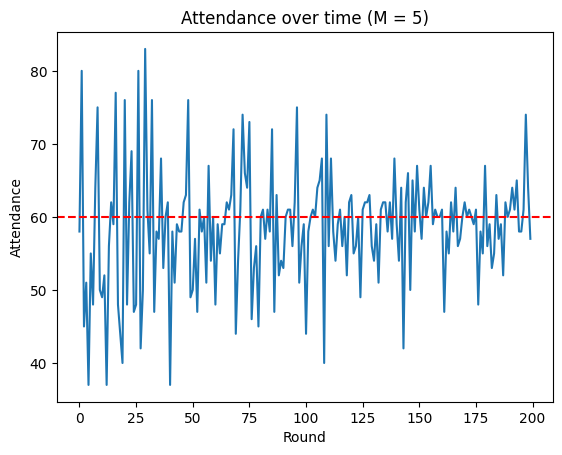

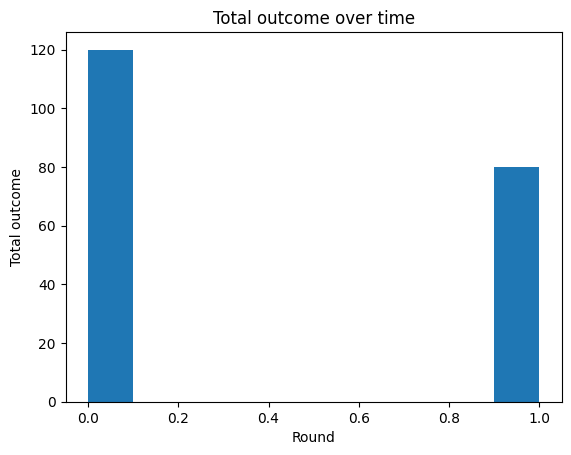

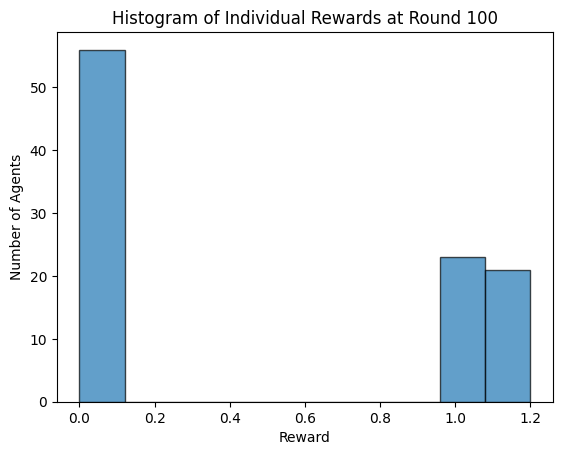

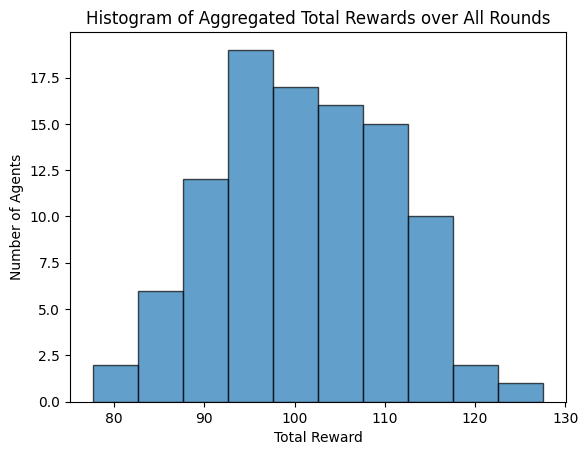

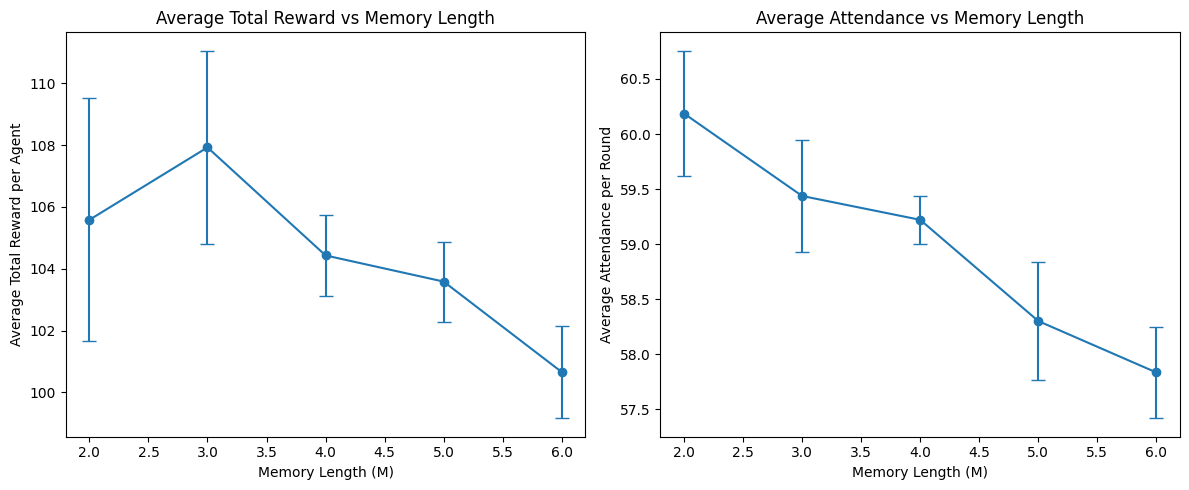

Gini coefficient of total rewards: nan


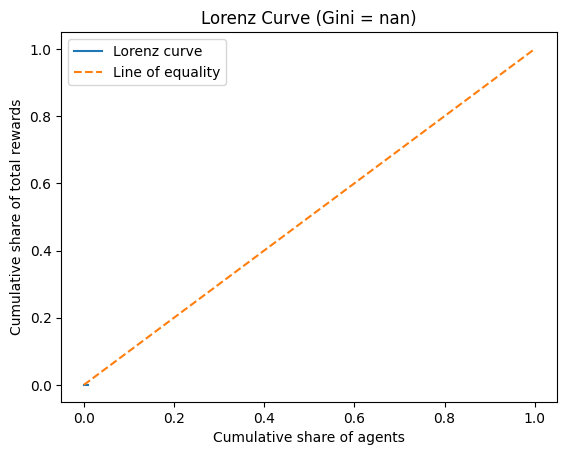

In [ ]:
if __name__ == "__main__":
    # Simulation parameters
    sim_params = {
        'N': 100,
        'C': 60,          # e.g. capacity of the bar
        'T': 200,        # time steps
        'alpha': 0.1,
        'gamma': 0.9,
        'epsilon': 0.1,   # initial exploration rate (will be modified in some plots)
        'beta': 0.2,
        'shared_memory': False
    }

    # Run a single simulation for demonstration and plot histograms of rewards:
    sim = Simulation(M=5, **sim_params)
    sim.run()

    # Plot agent rewards
    #sim.plot_agent_rewards(all = True)

    # Plot total rewards
    #sim.plot_total_rewards()

    # Plot total attendance
    sim.plot_attendance()
    plt.show()
    sim.plot_total_outcome()
    plt.show()

    # Plot histogram of individual rewards for a specific round (e.g. round 100)
    sim.plot_individual_rewards_histogram(round_index=100)

    # Plot histogram of aggregated total rewards over all rounds
    sim.plot_individual_rewards_histogram(round_index=None)

    # Run multiple simulations for different memory lengths (M)
    memory_values = [2, 3, 4, 5, 6]
    results = run_simulations_for_memory_lengths(memory_values, num_realizations=10, **sim_params)
    plot_results_vs_memory(results)
    sim = Simulation(M=5, **sim_params)

    # Compute and print Gini
    #print("Gini coefficient of total rewards:", sim.gini_coefficient())

    # Plot Lorenz curve
    #sim.plot_lorenz_curve()


In [ ]:
sim.print_q_tables()  # output each agent's learned Q-values

Agent 0 Q-table:
  State (0, 0, 0): [Q0=0.41, Q1=1.63]
  State (0, 0, 1): [Q0=0.68, Q1=0.00]
  State (0, 1, 0): [Q0=0.27, Q1=0.75]
  State (1, 0, 0): [Q0=1.09, Q1=0.00]
  State (0, 1, 1): [Q0=0.77, Q1=0.00]
  State (1, 1, 0): [Q0=0.04, Q1=1.23]
  State (1, 0, 1): [Q0=0.85, Q1=0.14]
  State (1, 1, 1): [Q0=0.48, Q1=0.00]
Agent 1 Q-table:
  State (0, 0, 0): [Q0=1.16, Q1=0.06]
  State (0, 0, 1): [Q0=1.17, Q1=0.00]
  State (0, 1, 0): [Q0=2.18, Q1=0.28]
  State (1, 0, 0): [Q0=0.00, Q1=1.23]
  State (0, 1, 1): [Q0=0.94, Q1=0.00]
  State (1, 1, 0): [Q0=0.00, Q1=1.41]
  State (1, 0, 1): [Q0=0.00, Q1=1.99]
  State (1, 1, 1): [Q0=0.03, Q1=0.66]
Agent 2 Q-table:
  State (0, 0, 0): [Q0=0.14, Q1=1.55]
  State (0, 0, 1): [Q0=0.80, Q1=0.01]
  State (0, 1, 0): [Q0=0.03, Q1=1.18]
  State (1, 0, 0): [Q0=0.22, Q1=1.30]
  State (0, 1, 1): [Q0=0.48, Q1=0.09]
  State (1, 1, 0): [Q0=0.76, Q1=0.00]
  State (1, 0, 1): [Q0=0.00, Q1=1.41]
  State (1, 1, 1): [Q0=0.38, Q1=0.00]
Agent 3 Q-table:
  State (0, 0, 0): [

# Fifth Version

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Modified Simulation with Softmax and Multiple Reward Schemes
class Agent:
    def __init__(self, M):
        self.M = M
        self.q_table = {}
        self.memory = [0] * M

    def _ensure_state(self, state):
        if state not in self.q_table:
            self.q_table[state] = [0.0, 0.0]

    def choose_action(self, state, epsilon, use_softmax=False, tau=1.0):
        self._ensure_state(state)
        q0, q1 = self.q_table[state]
        if use_softmax:
            # Softmax selection
            prefs = np.array([q0, q1]) / tau
            exps = np.exp(prefs - np.max(prefs))
            probs = exps / exps.sum()
            return np.random.choice([0,1], p=probs)
        else:
            # Epsilon-greedy
            if random.random() < epsilon:
                return random.choice([0,1])
            return 0 if q0 > q1 else 1

    def update_Q(self, s, a, r, s2, alpha, gamma):
        self._ensure_state(s); self._ensure_state(s2)
        current = self.q_table[s][a]
        target = r + gamma * max(self.q_table[s2])
        self.q_table[s][a] = current + alpha * (target - current)

    def update_memory(self, outcome):
        self.memory.append(outcome)
        if len(self.memory) > self.M:
            self.memory.pop(0)

    def get_state(self):
        return tuple(self.memory[-self.M:])

class Simulation:
    def __init__(self, N=100, C=60, M=3, T=200,
                 alpha=0.1, gamma=0.0,
                 epsilon=0.1, tau=1.0, use_softmax=False,
                 beta=0.0, reward_scheme='binary'):
        self.N, self.C, self.M, self.T = N, C, M, T
        self.alpha, self.gamma = alpha, gamma
        self.epsilon, self.tau, self.use_softmax = epsilon, tau, use_softmax
        self.beta, self.reward_scheme = beta, reward_scheme
        self.agents = [Agent(M) for _ in range(N)]
        self.attendance = []
        self.entropy = []

    def run(self):
        for t in range(self.T):
            # choose actions
            states = [agent.get_state() for agent in self.agents]
            actions = [agent.choose_action(s, self.epsilon, self.use_softmax, self.tau)
                       for agent, s in zip(self.agents, states)]
            # attendance outcome
            attend_count = sum(actions)
            self.attendance.append(attend_count)
            # compute base rewards
            base = []
            for a in actions:
                if self.reward_scheme=='binary':
                    r = 1.0 if ((a==1 and attend_count<=self.C) or (a==0 and attend_count>self.C)) else 0.0
                elif self.reward_scheme=='distance':
                    r = 1 - abs(attend_count - self.C)/self.N
                else:
                    r = 1.0
                base.append(r)
            # apply herding beta (bonus for matching minority)
            rewards = base.copy()
            minority = 1 if attend_count<=self.C else 0
            for i,a in enumerate(actions):
                if a==minority:
                    rewards[i] += self.beta
            # update Q and memory
            next_states = []
            for agent in self.agents:
                agent.update_memory(1 if attend_count>self.C else 0)
                next_states.append(agent.get_state())
            for i,agent in enumerate(self.agents):
                agent.update_Q(states[i], actions[i], rewards[i], next_states[i],
                               self.alpha, self.gamma)
            # compute entropy of action distribution
            p = np.mean(actions)
            if p in (0,1):
                self.entropy.append(0.0)
            else:
                self.entropy.append(- (p*np.log2(p) + (1-p)*np.log2(1-p)))

    def metrics(self):
        attend = np.array(self.attendance)
        ent = np.array(self.entropy)
        return {
            'mean_attendance': attend.mean(),
            'volatility': attend.var(),
            'mean_entropy': ent.mean()
        }

# Function to sweep a parameter
def sweep(param_name, values, sims=10, **base_params):
    results = {param_name: [], 'attendance': [], 'volatility': [], 'entropy': []}
    for v in tqdm(values, desc=f"Sweeping {param_name}"):
        metrics = []
        for _ in range(sims):
            params = base_params.copy()
            params[param_name] = v
            sim = Simulation(**params)
            sim.run()
            metrics.append(sim.metrics())
        results[param_name].append(v)
        results['attendance'].append(np.mean([m['mean_attendance'] for m in metrics]))
        results['volatility'].append(np.mean([m['volatility'] for m in metrics]))
        results['entropy'].append(np.mean([m['mean_entropy'] for m in metrics]))
    return results

# Base simulation parameters
#base = {
#    'N': 100, 'C': 50, 'M': 3, 'T': 200,
#    'alpha': 0.1, 'gamma': 0.0,
#    'epsilon': 0.1, 'tau': 1.0, 'use_softmax': False,
#    'beta': 0.0, 'reward_scheme': 'binary'
#}

# Define parameter ranges
#ranges = {
#    'M': [1,2,3,5,8],
#    'C': [30,40,50,60,70],
#    'epsilon': [0.0, 0.1, 0.3, 0.5, 0.9],
#    'tau': [0.1, 0.5, 1.0, 2.0, 5.0],
#    'beta': [0.0, 0.1, 0.2, 0.5],
#    'alpha': [0.01,0.1,0.5,0.9],
#    'gamma': [0.0,0.5,0.9],
#    'reward_scheme': ['binary', 'distance']
#}

# Perform sweeps
#sweeps = {}
#for param, vals in ranges.items():
    # For tau sweep, enable softmax
#    params = base.copy()
#    if param=='tau':
#        params['use_softmax'] = True
#    if isinstance(vals[0], str):
        # categorical sweep for reward_scheme
#        sw = sweep(param, vals, sims=5, **params)
#    else:
#        sw = sweep(param, vals, sims=20, **params)
#    sweeps[param] = sw

# Plotting function
#def plot_sweep(res, param_name):
#    vals = res[param_name]
#    plt.figure(figsize=(12,4))
#    plt.subplot(1,3,1)
#    plt.plot(vals, res['attendance'], '-o')
#    plt.xlabel(param_name); plt.ylabel('Mean Attendance')
#    plt.subplot(1,3,2)
#    plt.plot(vals, res['volatility'], '-o')
#    plt.xlabel(param_name); plt.ylabel('Attendance Variance')
#    plt.subplot(1,3,3)
#    plt.plot(vals, res['entropy'], '-o')
#    plt.xlabel(param_name); plt.ylabel('Mean Entropy')
#    plt.suptitle(f"Sweep: {param_name}")
#    plt.tight_layout()
#    plt.show()

# Generate plots for each sweep
#for param, res in sweeps.items():
#    plot_sweep(res, param)

AttributeError: 'Agent' object has no attribute 'total_rewards'

Metrics: {'mean_attendance': np.float64(68.205), 'volatility': np.float64(120.392975), 'mean_entropy': np.float64(0.8547018952723306)}
Gini: 0.1662851940047625
Jain's index: 0.9217902314182622
Reward entropy: 4.563191774841169


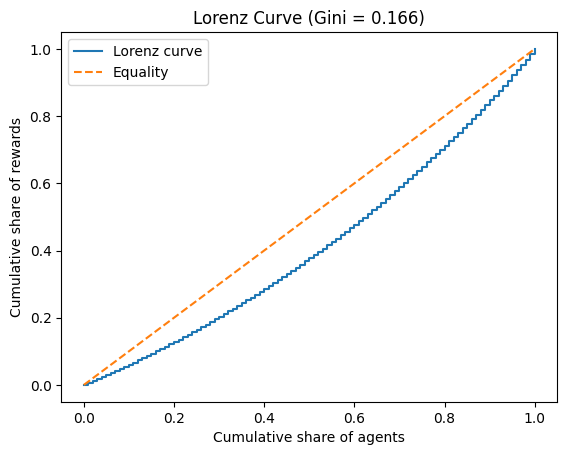

In [ ]:
import os
# --- limit BLAS threads if you hit resource errors ---
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"]        = "1"
os.environ["MKL_NUM_THREADS"]        = "1"

import random
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, M):
        self.M = M
        self.q_table = {}
        self.memory = [0] * M
        self.rewards_total = 0.0      # ← track cumulative reward

    def total_rewards(self):
        return self.rewards_total   # ← expose it

    def _ensure_state(self, state):
        if state not in self.q_table:
            self.q_table[state] = [0.0, 0.0]

    def choose_action(self, state, epsilon, use_softmax=False, tau=1.0):
        self._ensure_state(state)
        q0, q1 = self.q_table[state]
        if use_softmax:
            prefs = np.array([q0, q1]) / tau
            exps  = np.exp(prefs - np.max(prefs))
            probs = exps / exps.sum()
            return np.random.choice([0, 1], p=probs)
        else:
            if random.random() < epsilon:
                return random.choice([0, 1])
            return 0 if q0 > q1 else 1

    def update_Q(self, s, a, r, s2, alpha, gamma):
        self._ensure_state(s); self._ensure_state(s2)
        current = self.q_table[s][a]
        target  = r + gamma * max(self.q_table[s2])
        self.q_table[s][a] = current + alpha * (target - current)

    def update_memory(self, outcome):
        self.memory.append(outcome)
        if len(self.memory) > self.M:
            self.memory.pop(0)

    def get_state(self):
        return tuple(self.memory[-self.M:])

class Simulation:
    def __init__(self, N=100, C=60, M=3, T=200,
                 alpha=0.1, gamma=0.0,
                 epsilon=0.1, tau=1.0, use_softmax=False,
                 beta=0.0, reward_scheme='binary'):
        self.N, self.C, self.M, self.T = N, C, M, T
        self.alpha, self.gamma = alpha, gamma
        self.epsilon, self.tau, self.use_softmax = epsilon, tau, use_softmax
        self.beta, self.reward_scheme = beta, reward_scheme
        self.agents = [Agent(M) for _ in range(N)]
        self.attendance = []
        self.entropy    = []

    def run(self):
        for _ in range(self.T):
            states  = [ag.get_state() for ag in self.agents]
            actions = [ag.choose_action(s, self.epsilon, self.use_softmax, self.tau)
                       for ag, s in zip(self.agents, states)]
            attend_count = sum(actions)
            self.attendance.append(attend_count)

            # --- base rewards ---
            base = []
            for a in actions:
                if   self.reward_scheme == 'binary':
                    r = 1.0 if ((a == 1 and attend_count <= self.C)
                                or (a == 0 and attend_count > self.C)) else 0.0
                elif self.reward_scheme == 'distance':
                    r = 1 - abs(attend_count - self.C)/self.N
                else:
                    r = 1.0
                base.append(r)

            # --- herding bonus ---
            rewards = base.copy()
            minority = 1 if attend_count <= self.C else 0
            for i,a in enumerate(actions):
                if a == minority:
                    rewards[i] += self.beta

            # ← update each agent's total
            for i,ag in enumerate(self.agents):
                ag.rewards_total += rewards[i]

            # update memories and Q‐values
            next_states = []
            for ag in self.agents:
                ag.update_memory(1 if attend_count > self.C else 0)
                next_states.append(ag.get_state())
            for i,ag in enumerate(self.agents):
                ag.update_Q(states[i], actions[i], rewards[i], next_states[i],
                            self.alpha, self.gamma)

            # entropy of choices
            p = np.mean(actions)
            ent = 0.0 if p in (0,1) else - (p*np.log2(p) + (1-p)*np.log2(1-p))
            self.entropy.append(ent)

    def metrics(self):
        arr   = np.array(self.attendance)
        ent   = np.array(self.entropy)
        return {
            'mean_attendance': arr.mean(),
            'volatility':      arr.var(),
            'mean_entropy':    ent.mean()
        }

    def gini_coefficient(self):
        R = np.array([ag.total_rewards() for ag in self.agents], float)
        if R.sum() == 0: return 0.0
        R_sorted = np.sort(R)
        n = len(R_sorted)
        i = np.arange(1, n+1)
        return (2*np.sum(i*R_sorted)/(n*R.sum()) - (n+1)/n)

    def jains_index(self):
        R = np.array([ag.total_rewards() for ag in self.agents], float)
        num = np.sum(R)**2
        den = self.N * np.sum(R**2)
        return num/den if den>0 else 0.0

    def reward_entropy(self):
        R = np.array([ag.total_rewards() for ag in self.agents], float)
        total = R.sum()
        if total == 0: return 0.0
        p = R/total; p = p[p>0]
        return -np.sum(p*np.log(p))

    def plot_lorenz_curve(self):
        R = np.array([ag.total_rewards() for ag in self.agents], float)
        R_s = np.sort(R)
        cum = np.insert(np.cumsum(R_s), 0, 0)
        if cum[-1] > 0: frac = cum/cum[-1]
        else: frac = cum
        x = np.linspace(0,1,len(frac))
        plt.plot(x, frac, drawstyle='steps-post', label='Lorenz curve')
        plt.plot([0,1],[0,1],'--', label='Equality')
        plt.title(f"Lorenz Curve (Gini = {self.gini_coefficient():.3f})")
        plt.xlabel("Cumulative share of agents")
        plt.ylabel("Cumulative share of rewards")
        plt.legend()
        plt.show()


# --- Example run ---
if __name__ == "__main__":
    sim = Simulation(N=100, C=60, M=3, T=200,
                     alpha=0.1, gamma=0.9,
                     epsilon=0.1, beta=0.2)
    sim.run()
    print("Metrics:",        sim.metrics())
    print("Gini:",           sim.gini_coefficient())
    print("Jain's index:",   sim.jains_index())
    print("Reward entropy:", sim.reward_entropy())
    sim.plot_lorenz_curve()

In [ ]:
import random
import numpy as np

class Agent:
    def __init__(self, M):
        self.M = M
        self.q_table = {}
        self.memory = [0]*M
        self.rewards_record = []
        self.attendance_record = []

    def _ensure_state(self, state):
        if state not in self.q_table:
            self.q_table[state] = [0.0, 0.0]

    def choose_action(self, state, epsilon, use_softmax=False, tau=1.0):
        self._ensure_state(state)
        q0, q1 = self.q_table[state]
        if use_softmax:
            # --- Softmax / Boltzmann exploration ---
            prefs = np.array([q0, q1]) / tau
            exps  = np.exp(prefs - prefs.max())
            probs = exps / exps.sum()
            return np.random.choice([0,1], p=probs)
        else:
            # --- Epsilon-greedy exploration ---
            if random.random() < epsilon:
                return random.choice([0,1])
            return 0 if q0>q1 else 1

    def update_Q(self, prev_state, action, reward, new_state, alpha, gamma):
        self._ensure_state(prev_state)
        self._ensure_state(new_state)
        current   = self.q_table[prev_state][action]
        target    = reward + gamma * max(self.q_table[new_state])
        self.q_table[prev_state][action] = current + alpha*(target-current)

    def update_memory(self, outcome):
        self.memory.append(outcome)
        if len(self.memory)>self.M:
            self.memory.pop(0)

    def get_state(self):
        return tuple(self.memory[-self.M:])

class Simulation:
    def __init__(self, N=100, C=60, M=3, T=100,
                 alpha=0.1, gamma=0.9,
                 epsilon=0.1, tau=1.0, use_softmax=False,
                 beta=0.0, shared_memory=True):
        self.N, self.C, self.M, self.T = N, C, M, T
        self.alpha, self.gamma          = alpha, gamma
        self.epsilon, self.tau          = epsilon, tau
        self.use_softmax, self.beta     = use_softmax, beta
        self.shared_memory              = shared_memory

        # data records
        self.attendance = []
        self.entropy    = []

        self.agents = [Agent(M) for _ in range(N)]
        if shared_memory:
            self.global_memory = [0]*M

    def run(self):
        for _ in range(self.T):
            # 1) states & actions
            if self.shared_memory:
                state = tuple(self.global_memory)
                states = [state]*self.N
            else:
                states = [ag.get_state() for ag in self.agents]

            actions = [
                ag.choose_action(
                    st, self.epsilon, self.use_softmax, self.tau
                )
                for ag,st in zip(self.agents, states)
            ]

            # 2) attendance & outcome
            A = sum(actions)
            self.attendance.append(A)
            outcome = 1 if A>self.C else 0

            # 3) base rewards
            rewards = []
            for a in actions:
                if a==1:
                    r = 1.0 if outcome==0 else 0.0
                else:
                    r = 1.0 if outcome==1 else 0.0
                rewards.append(r)

            # 4) herding bonus β
            minority = 1 if A<=self.C else 0
            for i,a in enumerate(actions):
                if a==minority:
                    rewards[i]+=self.beta

            # 5) update memories
            if self.shared_memory:
                self.global_memory.append(outcome)
                if len(self.global_memory)>self.M:
                    self.global_memory.pop(0)
                next_states = [tuple(self.global_memory)]*self.N
            else:
                for ag in self.agents:
                    ag.update_memory(outcome)
                next_states = [ag.get_state() for ag in self.agents]

            # 6) Q‑updates & record per‑agent data
            for i,ag in enumerate(self.agents):
                ag.update_Q(states[i], actions[i],
                            rewards[i], next_states[i],
                            self.alpha, self.gamma)
                ag.rewards_record.append(rewards[i])
                ag.attendance_record.append(actions[i])

            # 7) entropy diagnostic
            p = A/self.N
            if p in (0,1):
                self.entropy.append(0.0)
            else:
                self.entropy.append(- (p*np.log2(p) + (1-p)*np.log2(1-p)))

    def metrics(self):
        """Return mean attendance, attendance variance, mean policy entropy."""
        arr = np.array(self.attendance)
        ent = np.array(self.entropy)
        return {
            'mean_attendance': arr.mean(),
            'volatility':     arr.var(),
            'mean_entropy':   ent.mean()
        }

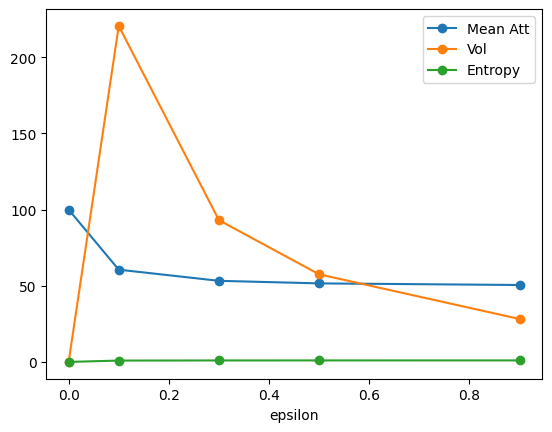

In [ ]:
def sweep(param, values, sims=20, **base_kwargs):
    results = {param:[], 'mean_attendance':[], 'volatility':[], 'mean_entropy':[]}
    for v in values:
        acc = {'ma':[], 'vol':[], 'ent':[]}
        for _ in range(sims):
            kwargs = dict(base_kwargs)
            kwargs[param] = v
            sim = Simulation(**kwargs)
            sim.run()
            m = sim.metrics()
            acc['ma'].append(m['mean_attendance'])
            acc['vol'].append(m['volatility'])
            acc['ent'].append(m['mean_entropy'])
        results[param].append(v)
        results['mean_attendance'].append(np.mean(acc['ma']))
        results['volatility'].append(np.mean(acc['vol']))
        results['mean_entropy'].append(np.mean(acc['ent']))
    return results

# Example usage:
base = dict(N=100,C=50,M=3,T=200,
            alpha=0.1,gamma=0.0,
            epsilon=0.1,tau=1.0,use_softmax=False,
            beta=0.0,shared_memory=False)
eps_vals = [0.0,0.1,0.3,0.5,0.9]
res = sweep('epsilon', eps_vals, sims=30, **base)

# Plot:
import matplotlib.pyplot as plt
plt.plot(res['epsilon'], res['mean_attendance'], '-o')
plt.plot(res['epsilon'], res['volatility'],    '-o')
plt.plot(res['epsilon'], res['mean_entropy'],   '-o')
plt.legend(['Mean Att','Vol','Entropy'])
plt.xlabel('epsilon')
plt.show()


Gini coefficient: 0.07309071278697887
Jain's fairness index: 0.9836483889074636
Reward entropy: 4.596712118950378


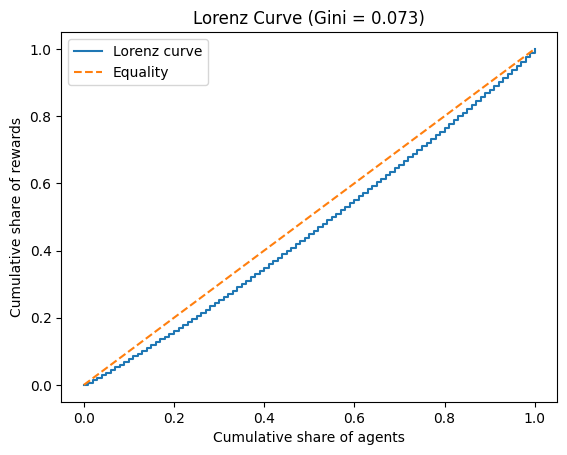

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    """
    An agent in the El Farol Bar simulation using Q-learning.
    """
    def __init__(self, M):
        self.M = M
        self.q_table = {}
        self.memory = [0] * M
        self.rewards_record = []

    def _ensure_state(self, state):
        if state not in self.q_table:
            self.q_table[state] = [0.0, 0.0]

    def choose_action(self, state, epsilon):
        self._ensure_state(state)
        if random.random() < epsilon:
            return random.choice([0, 1])
        else:
            q0, q1 = self.q_table[state]
            if q0 == q1:
                return random.choice([0, 1])
            return 0 if q0 > q1 else 1

    def update_Q(self, prev_state, action, reward, new_state, alpha, gamma):
        self._ensure_state(prev_state)
        self._ensure_state(new_state)
        current_Q = self.q_table[prev_state][action]
        max_Q_next = max(self.q_table[new_state])
        self.q_table[prev_state][action] = current_Q + alpha * (reward + gamma * max_Q_next - current_Q)

    def update_memory(self, outcome):
        self.memory.append(outcome)
        if len(self.memory) > self.M:
            self.memory.pop(0)

    def get_state(self):
        if len(self.memory) < self.M:
            return tuple([0] * (self.M - len(self.memory)) + self.memory)
        else:
            return tuple(self.memory[-self.M:])

    def total_rewards(self):
        return sum(self.rewards_record)


class Simulation:
    """
    El Farol Bar simulation environment with inequality metrics.
    """
    def __init__(self, N=100, C=60, M=3, T=200, alpha=0.1, gamma=0.9,
                 epsilon=0.1, beta=0.0, shared_memory=True):
        self.N = N
        self.C = C
        self.M = M
        self.T = T
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.beta = beta
        self.shared_memory = shared_memory

        self.agents = [Agent(M) for _ in range(N)]
        self.attendance_record = []
        self.total_rewards_record = []
        if shared_memory:
            self.global_memory = [0] * M
        else:
            self.global_memory = None

    def run(self):
        for _ in range(self.T):
            state = tuple(self.global_memory) if self.shared_memory else None
            actions, states = [], []
            for agent in self.agents:
                s = state if self.shared_memory else agent.get_state()
                a = agent.choose_action(s, self.epsilon)
                actions.append(a)
                states.append(s)
            attendees = sum(actions)
            self.attendance_record.append(attendees)
            outcome = 1 if attendees > self.C else 0
            rewards = []
            for i, agent in enumerate(self.agents):
                a = actions[i]
                r = 1.0 if (a == 1 and outcome == 0) or (a == 0 and outcome == 1) else 0.0
                rewards.append(r)
            # herding bonus
            for i, r in enumerate(rewards):
                if r > 0:
                    j = random.choice([x for x in range(self.N) if x != i])
                    if actions[j] == actions[i]:
                        rewards[i] += self.beta
            self.total_rewards_record.append(sum(rewards))
            for i, agent in enumerate(self.agents):
                agent.rewards_record.append(rewards[i])
            # update memory
            if self.shared_memory:
                self.global_memory.append(outcome)
                if len(self.global_memory) > self.M:
                    self.global_memory.pop(0)
            else:
                for agent in self.agents:
                    agent.update_memory(outcome)
            # update Q
            new_state = tuple(self.global_memory) if self.shared_memory else None
            for i, agent in enumerate(self.agents):
                agent.update_Q(states[i], actions[i], rewards[i],
                               new_state if self.shared_memory else agent.get_state(),
                               self.alpha, self.gamma)

    def gini_coefficient(self):
        rewards = np.array([agent.total_rewards() for agent in self.agents], dtype=float)
        if rewards.sum() == 0:
            return 0.0
        rewards = np.sort(rewards)
        n = len(rewards)
        index = np.arange(1, n+1)
        return (2.0 * np.sum(index * rewards) / (n * rewards.sum()) - (n + 1) / n)

    def jains_index(self):
        R = np.array([agent.total_rewards() for agent in self.agents], dtype=float)
        num = np.sum(R)**2
        den = self.N * np.sum(R**2)
        return num/den if den > 0 else 0.0

    def reward_entropy(self):
        R = np.array([agent.total_rewards() for agent in self.agents], dtype=float)
        total = R.sum()
        if total == 0:
            return 0.0
        p = R / total
        # filter zero probabilities
        p = p[p > 0]
        return -np.sum(p * np.log(p))

    def plot_lorenz_curve(self):
        rewards = np.array([agent.total_rewards() for agent in self.agents], dtype=float)
        rewards_sorted = np.sort(rewards)
        cum_rewards = np.cumsum(rewards_sorted)
        cum_rewards = np.insert(cum_rewards, 0, 0)
        frac_rewards = cum_rewards / cum_rewards[-1] if cum_rewards[-1] > 0 else cum_rewards
        frac_agents = np.linspace(0, 1, len(frac_rewards))
        plt.figure()
        plt.plot(frac_agents, frac_rewards, drawstyle='steps-post', label='Lorenz curve')
        plt.plot([0,1], [0,1], '--', label='Equality')
        plt.title(f"Lorenz Curve (Gini = {self.gini_coefficient():.3f})")
        plt.xlabel("Cumulative share of agents")
        plt.ylabel("Cumulative share of rewards")
        plt.legend()
        plt.show()

# Run and demonstrate metrics
sim = Simulation(N=100, C=60, M=3, T=200, alpha=0.1, gamma=0.9, epsilon=0.1, beta=0.2, shared_memory=False)
sim.run()
print("Gini coefficient:", sim.gini_coefficient())
print("Jain's fairness index:", sim.jains_index())
print("Reward entropy:", sim.reward_entropy())
sim.plot_lorenz_curve()

#Plotting

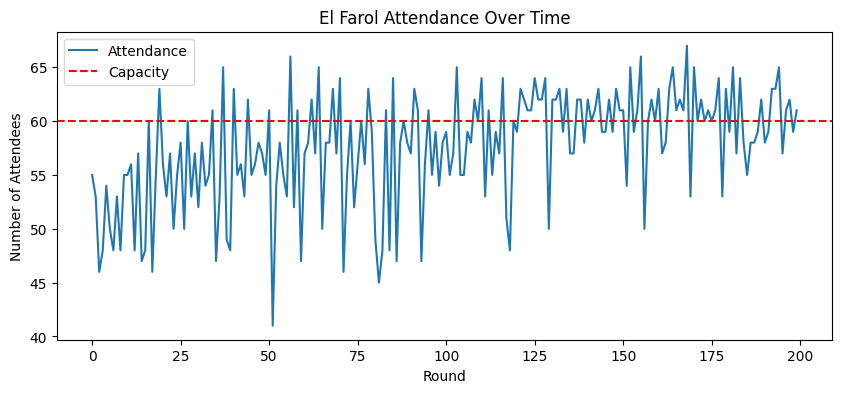

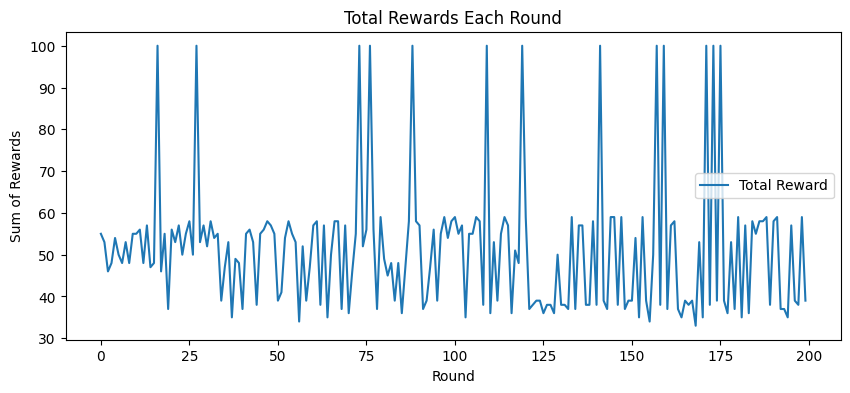

Average attendance over 200 rounds: 57.59
Average total reward over 200 rounds: 51.30


In [ ]:
    # Plot attendance over time
    plt.figure(figsize=(10,4))
    plt.plot(attendances, label='Attendance')
    plt.axhline(C, color='r', linestyle='--', label='Capacity')
    plt.title('El Farol Attendance Over Time')
    plt.xlabel('Round')
    plt.ylabel('Number of Attendees')
    plt.legend()
    plt.show()

    # Plot total reward over time
    plt.figure(figsize=(10,4))
    plt.plot(rewards, label='Total Reward')
    plt.title('Total Rewards Each Round')
    plt.xlabel('Round')
    plt.ylabel('Sum of Rewards')
    plt.legend()
    plt.show()

    # Some final stats
    avg_attendance = np.mean(attendances)
    avg_reward = np.mean(rewards)
    print(f"Average attendance over {T} rounds: {avg_attendance:.2f}")
    print(f"Average total reward over {T} rounds: {avg_reward:.2f}")

In [ ]:
import pandas as pd
attendances_df = pd.DataFrame({'Attendance': attendances, 'Round' : range(1,201)})

In [ ]:
rolling_window = 5
attendances_rolling = attendances_df['Attendance'].rolling(window=rolling_window).std()
rolling_mean = attendances_rolling.mean()

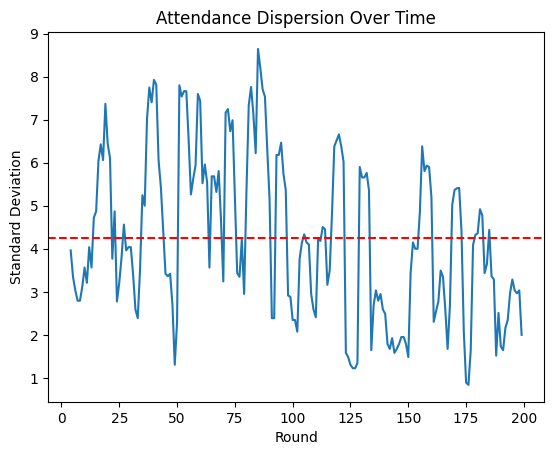

In [ ]:
plt.plot(attendances_rolling)
plt.ylabel("Standard Deviation")
plt.xlabel("Round")
plt.axhline(rolling_mean, color='r', linestyle='--')
plt.title("Attendance Dispersion Over Time")
plt.show()

Experimentation with a model where we also track every agent's period-by-period statistics.